In [1]:
#importing the necessary libraries to read files in, export them out, and basic
#functions
import numpy as np
import pandas as pd
from google.colab import files
import io
import imageio
import cv2
import glob
import os
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from shapely.geometry import Point, Polygon
from urllib.request import urlopen
import plotly.express as px
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:
#importing the processed file into the current notebook
upload = files.upload()
df = pd.read_csv(io.BytesIO(upload['datacleanedup.csv']))

Saving datacleanedup.csv to datacleanedup.csv


In [4]:
#deleting the redundant columns
df.drop(columns = ['Unnamed: 0', 'State Code', 'County Code'], inplace = True)

In [6]:
#renaming the columns to allow for easy merging
df.rename(columns = {'location': 'id'}, inplace = True)

In [7]:
#Creating a function that would add values corresponding to the population change of each county

def population_delta(df):
  '''
  Adds a new column calculating population change of a given county on a yearly cadence
  when the year is 1969, the column value is set to 0 as no prior data is given.
  Meant to operate upon using groupby by 'id'

  inputs: the dataframe containing one county's historic population count
  output: the same dataframe with the added column

  '''

  #storing the population column for the county as an array
  a = np.array(df['Population'])

  #saving the first value to (i.e, 1969)
  val = a[0]

  #adding a value to the start of the array to shift the series down
  #the inserted value is that of 1969's population data - as to ensure
  #population growth rate for 1969 is 0
  a = np.insert(a, 0, val)

  #deleting the last value to keep the array of the same length
  a = np.delete(a, -1)

  #adding the array as a new column to df. Essentially serves to display the
  #previous year's population
  df['pop2'] = a

  #adding a new column to calculate the percentage change between the current
  #population, and the previous year's population
  df['change'] = df['pop2']/df['Population']
  df['change'] = 1 - df['change']
  df['change'] = df['change'] * 100
  return df

In [8]:
#applying the function by grouping by ID. ID serves as a unique combination
#to represent each county. The first two digits are of the state, and the last
#three digits are of the county
dfc = df.groupby(['id']).apply(population_delta)

In [9]:
#importing a geojson file with information regarding the shape of each county in the US for plotting purposes
geodata = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

In [10]:
#turning the id column into integers
geodata['id'] = geodata['id'].astype(int)

In [11]:
#merging the df on the id column
#note: geodata is of type geodataframe, while df is of a pandas dataframe
merged = geodata.merge(dfc, on = 'id')

In [12]:
#dropping the unecessary columns
merged.drop(columns = ['GEO_ID', 'COUNTY', 'CENSUSAREA'], inplace = True)

In [14]:
#using a mask to run the plot on a test year. Removing Alaska, Hawaii, Puerto Rico to limit the plot to
#mainland USA
mask = (merged['Year'] == 1989) & (merged['STATE'] != '02') & (merged['STATE'] != '15') & (merged['STATE'] != '72')
#storing the filtered dataframe as dfplot
dfplot = merged[mask]

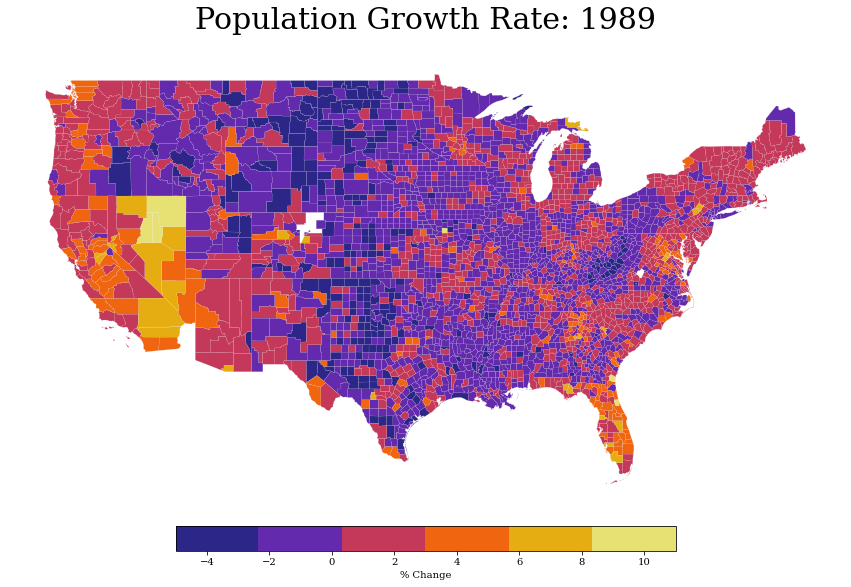

In [15]:
#Using seaborn to create a font dictionary
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

#creating the plot
fig, ax = plt.subplots(1, figsize=(15,10))

#storing the year's value for the title
year = dfplot['Year'].values[1]

#using the CMRmap color palette
#the contrast color is without any change conveniently set at 0% Making it clear
#the distinction between population decline and growth
cmap = ListedColormap(sns.color_palette("CMRmap"))

#plotting the graph. The range of the percentage values is set to [-5,11] upon
#inspection of the data
dfplot.plot(column='change', cmap = cmap, linewidth=0.1, ax=ax, edgecolor='0.9', legend = False, vmin = -5, vmax = 11)

#setting the title of the plot
ax.set_title(label = ('Population Growth Rate: ' + str(year)), fontdict ={'size': 30}, pad = 25)
ax.axis('off')

#creating the colorbar
norm = plt.Normalize(vmin = -5, vmax = 11)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),orientation='horizontal',fraction=0.046, pad=0.04, label = '% Change')

In [ ]:
#running a loop to create and save a plot for each year in the required range

#creating a list of the years
years_list = [x for x in range(1969,2021)]

for year in years_list:
  #setting the year to iterated year, once again limiting to mainland USA
  mask = (merged['Year'] == year) & (merged['STATE'] != '02') & (merged['STATE'] != '15') & (merged['STATE'] != '72')
  dfplot = merged[mask]

  #same as in the test run
  sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
  fig, ax = plt.subplots(1, figsize=(15,10))
  year = dfplot['Year'].values[1]
  cmap = ListedColormap(sns.color_palette("CMRmap"))
  dfplot.plot(column='change', cmap = cmap, linewidth=0.1, ax=ax, edgecolor='0.9', legend = False, vmin = -5, vmax = 11)
  ax.set_title(label = ('Population Growth Rate: ' + str(year)), fontdict ={'size': 30}, pad = 25)
  ax.axis('off')
  norm = plt.Normalize(vmin = -5, vmax = 11)
  fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),orientation='horizontal',fraction=0.046, pad=0.04, label = '% Change')

  #saving the plot for each year. DPI is set to 300 as to ensure it would not be
  #too large to stitch the jpgs together as a GIF
  chart = fig.get_figure()
  plt.savefig("ver2" + (str(year) + '_popgrowth.jpg'),dpi = 300)

In [ ]:
#collecting the filenames
filenames = [('/content/' +"ver2"+ str(i) + '_popgrowth.jpg') for i in range(1970,2021)]

#Stitching the images together in a gif file
with imageio.get_writer('collection.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

images = list(map(lambda filename: imageio.imread(filename), filenames))

In [ ]:
#saving the gif and setting the duration of each image to be 1 second
path = '/content'
image_folder = os.fsencode(path)

imageio.mimsave(os.path.join('collection.gif'), images, duration = 1)